# Generating Masks for VST fields

## This notebook aims to automatically generate a mask for a photometric VST field according to the 'radial' criteria

### Previous procedure done:
- Using the r band image (more spurious objects) and selecting visually the ghost generated by the brightest stars
- Matching our catalog with GAIA to obtain the true RA, DEC of these stars and reject false stars
-

### Procedure done in this notebook:
- INPUT: handmade ghosts, catalog of bright stars and VST field 
- Finding the effective center of the field in pixels 
- Step 1: finding a linear relation for the distance 'star-handmade ghost' as a function of the distance 'star-center of the field'
- Step 2: verifying that the angle 'star-center of the field' corresponds to the angle 'handmade ghost-center of the field'
- Step 3: finding a simple relation for the handmade ghost radius as a function of the star magnitude
- Voilà... now putting togheter the distance relation, the angle and the radius you can generate an 'automatic' mask using only RA, DEC and MAG_AUTO of the brightest stars and compare it with the handmade mask

### Working on:
- OUTPUT: Generate a .fits immage with the same dimensions as the original but containing only the mask 

### Future improvements:
- Adding the stars halo and spikes (few sorgents according to SExtractor)
- Work on the conversion from pixels to WCS
- Testing the validity of the procedure for the other bands
- Determine the level of 'spuriousness' of the sources into the ghosts (final goal of the mask)
- 'Pipeline': once that the mask is calibrated, implement an easy way to mask other fields, skiping the handmade ghost section and using only the VST image and RA, DEC and MAG_AUTO of the brightest stars from GAIA 

### Manual steps done (working on finding an automatic way): 
- spot fake stars on the BIG_STARS catalogue -> will be solved by matching our catalog with GAIA 
- ordering the regions file with the catalogue (this was a really ugly thing that I've done... never again!)


# Importing libraries

In [1]:
import time
import healpy
import logging
import pyregion
import numpy as np
from   numpy import linalg
from   astropy.io import fits
from   matplotlib import rcParams
from   matplotlib.path import Path
from   matplotlib import pyplot as plt
import matplotlib.lines as lines
import matplotlib.patches as patches
rcParams["font.size"] = 18

# Loading data 
All the paths to files loaded are here, if you're using this notebook from another computer, you just have to change this cell

In [18]:
handmadeghosts  = 'https://raw.githubusercontent.com/nicostrada/photo_mask/master/data/Handmade_ghosts_m0416.reg'
stars           = 'https://raw.githubusercontent.com/nicostrada/photo_mask/master/data/M0416_rband_BIGSTARS2_header.cat'

# This file is not online because it's 3.6 GB!
image           = '/users/nestrada/Documents/Game/VST_GAME/M0416/rband/images/game_macsj0416_omegacam_sdss_r_20190614_g2sw.fits'

# Obtaining the effective center of the field

In [19]:
with fits.open(image) as hdulist:
    hdulist.info()
    data = hdulist[0].data
    hdu  = hdulist[0]

n1  = hdu.header['NAXIS1']
n2  = hdu.header['NAXIS2']

# Finding the effective dimensions of the image
for i in range(n1):
    if data[i,:].min() != 0:
        y_min = i 
        break
for i in range(y_min,n1):
    if data[i,:].min() == 0:
        y_max = i 
        break
for i in range(n1):
    if data[:,i].min() != 0:
        x_min = i 
        break
for i in range(x_min,n1):
    if data[:,i].min() == 0:
        x_max = i 
        break
print(x_min, y_min)
print(x_max, y_max)

# Effective central x pixel of the field
xc = np.floor((x_min+x_max)/2).astype(int)

# Effective central y pixel of the field
yc = np.floor((y_min+y_max)/2).astype(int)

print(xc,yc)

# One last step hand-made :(
# ID of fake stars in the catalog
fake_id = [58829,91745,94077,133181,148524,170232,164123] 

Filename: /users/nestrada/Documents/Game/VST_GAME/M0416/rband/images/game_macsj0416_omegacam_sdss_r_20190614_g2sw.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     446   (30000, 30000)   float32   
6966 4610
25848 24507
16407 14558


# Seting XY for the ghosts and stars

In [4]:
# Loading the HANDMADE ghosts! 
ghosts = pyregion.open(handmadeghosts) 

xg = []
yg = []
rg = []
for i in range(len(ghosts)):
    xg.append(ghosts[i].coord_list[0])
    yg.append(ghosts[i].coord_list[1])
    rg.append(ghosts[i].coord_list[2])
    
# X coordinate of the HANDMADE ghosts
xg = np.array(xg)
# Y coordinate of the HANDMADE ghosts
yg = np.array(yg)
# Radius of the HANDMADE ghosts
rg = np.array(rg)


# Excluding fake stars from the catalog
big_stars = np.loadtxt(stars)
fake_mask = np.isin(big_stars[:,0],fake_id,invert=True) 
stars = big_stars[fake_mask]                            

# Calling the X, Y and MAG_AUTO of stars from our catalog - See Apendix for the header of the catalog
id_star = stars[:,0]
xs = stars[:,5]
ys = stars[:,6]
mags= stars[:,7]


# Input plot

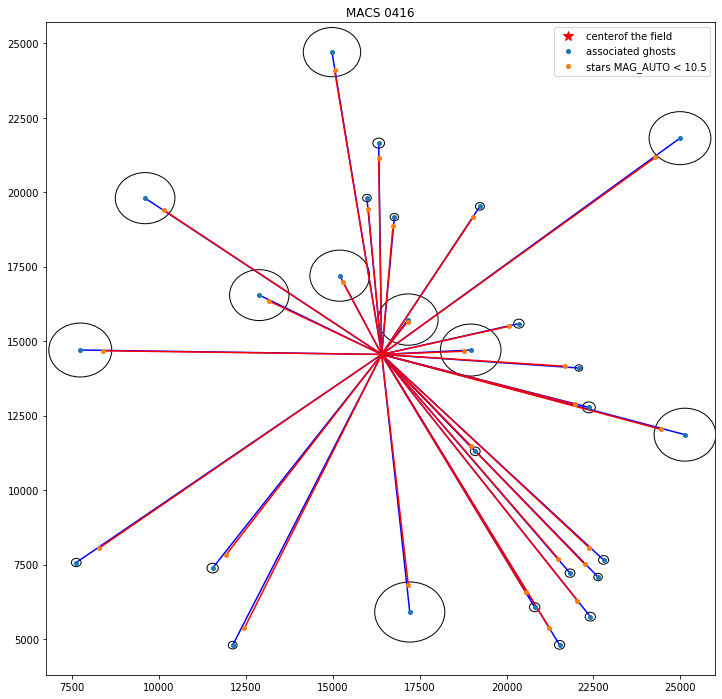

In [5]:
plt.figure(figsize=(12,12))
fig = plt.gcf()
ax  = fig.gca()
for i in range(len(xg)):
    ax.add_artist(patches.Circle((xg[i], yg[i]), rg[i],fill=False))       # HANDMADE ghosts
    plt.plot([xc,xg[i]],[yc,yg[i]],c='b')                                 # Center of the field - center of the HANDMADE ghost (blue line)
    plt.plot([xc,xs[i]],[yc,ys[i]],c='r')                                 # Center of the field - stars (red line)
    
plt.title('MACS 0416')
plt.plot(xc,yc,'*',label='centerof the field',c='r',markersize=10)        # Marker at the center of the field
plt.plot(xg,yg,'.',label='associated ghosts',markersize=8)                # Center of the HANDMADE ghosts
plt.plot(xs,ys,'.',label='stars MAG_AUTO < 10.5',markersize=8)            # Stars
plt.legend()
plt.show()

# Step 1: 
## Finding a linear relation for the distance 'star-handmade ghost' as a function of the distance 'star-center of the field'

In [6]:
x_s = np.abs(xc-xs)
y_s = np.abs(yc-ys)

x_g = np.abs(xc-xg)
y_g = np.abs(yc-yg)

ds = np.sqrt(x_s**2+y_s**2)
dg = np.sqrt(x_g**2+y_g**2)

delta_d = dg - ds

(27,)


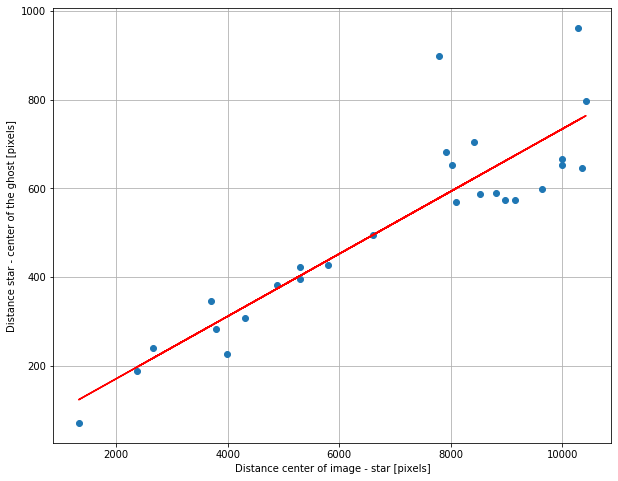

In [7]:
A    = np.vstack([ds, np.ones(len(ds))]).T
m, c = np.linalg.lstsq(A,delta_d,rcond=None)[0]
d_star_ghost = m*ds+c
plt.figure(figsize=(10,8))
plt.plot(ds,delta_d,'o')
plt.plot(ds,d_star_ghost,'r')
plt.grid()
plt.xlabel('Distance center of image - star [pixels]')
plt.ylabel('Distance star - center of the ghost [pixels]')
print(d_star_ghost.shape)

# Step 2: 
## Verifying that the angle 'star-center of the field' corresponds to the angle 'handmade ghost-center of the field'

In [8]:
ang_s = np.rad2deg(np.arctan(y_s/x_s)) # Theoretical angle between x axes and the star
ang_g = np.rad2deg(np.arctan(y_g/x_g)) # Measured angle between x axes and the star

delta_ang = (ang_g-ang_s)/ang_g        # Relative error between the theoretical and measured angle


Text(0.5, 1.0, 'Relative error between angles')

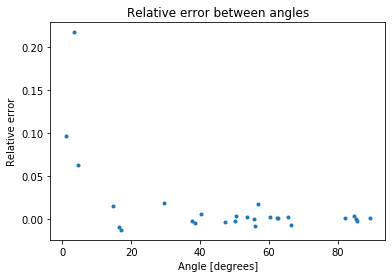

In [9]:
# This plot shows the error between the position of the star and the position of the HANDMADE ghost
plt.plot(ang_g,delta_ang,'.')
plt.xlabel('Angle [degrees]')
plt.ylabel('Relative error')
plt.title('Relative error between angles')

# Step 3: 
## Finding a simple relation for the handmade ghost radius as a function of the star magnitude

Text(0, 0.5, 'Ghost radius [pixels]')

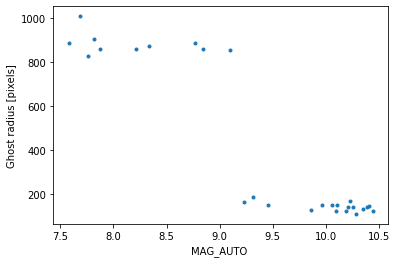

In [10]:
# This plot shows the diameter of the HANDMADE ghosts as a function of the MAG_AUTO
plt.plot(mags,rg,'.')
plt.xlabel('MAG_AUTO ')
plt.ylabel('Ghost radius [pixels]')

# AUTOMATIC GHOST GENERATOR
### Using only the info contained in the catalog and the relations obtained in the previous 3 plots (distance, angle, radius)

In [11]:
# Defining xy distances star-AUTOMATIC ghost
dx = d_star_ghost*np.cos(np.arctan(y_s/x_s))
dy = d_star_ghost*np.sin(np.arctan(y_s/x_s))

ghost_x = np.empty(len(xs))
ghost_y = np.empty(len(xs))

for i in range(len(xs)):
    if xs[i] > xc and ys[i] > yc:
        ghost_x[i] = xs[i] + dx[i]
        ghost_y[i] = ys[i] + dy[i]
    elif xs[i] < xc and ys[i] > yc:
        ghost_x[i] = xs[i] - dx[i]
        ghost_y[i] = ys[i] + dy[i]
    elif xs[i] < xc and ys[i] < yc:
        ghost_x[i] = xs[i] - dx[i]
        ghost_y[i] = ys[i] - dy[i]
    elif xs[i] > xc and ys[i] < yc:
        ghost_x[i] = xs[i] + dx[i]
        ghost_y[i] = ys[i] - dy[i]

# Defining the radius of the AUTOMATIC ghost
ghost_rad = np.ones(len(ghost_x))
for i in range(len(ghost_x)):
    if mags[i] < 7.9:
        ghost_rad[i] = 950
    elif mags[i] < 9.1:
        ghost_rad[i] = 900
    elif mags[i] >= 9.10:
        ghost_rad[i] = 170

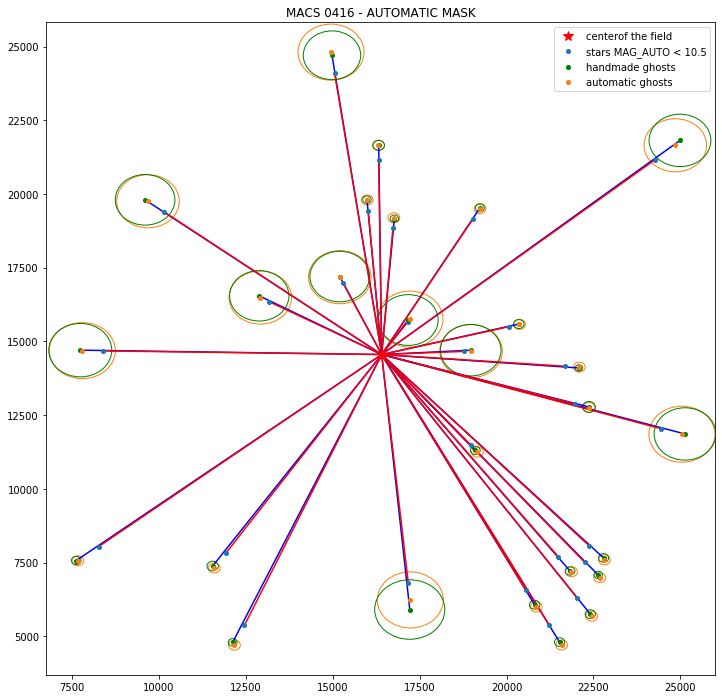

In [12]:
plt.figure(figsize=(12,12))
fig = plt.gcf()
ax  = fig.gca()
for i in range(len(xg)):
    ax.add_artist(patches.Circle((ghost_x[i], ghost_y[i]), ghost_rad[i],fill=False, color='tab:orange')) # Ghosts - AUTOMATIC
    ax.add_artist(patches.Circle((xg[i], yg[i]), rg[i],fill=False, color='g'))                           # Ghosts - HANDMADE
    plt.plot([xc,xg[i]],[yc,yg[i]],c='b')
    plt.plot([xc,xs[i]],[yc,ys[i]],c='r')                            # Distance center - stars
    
plt.title('MACS 0416 - AUTOMATIC MASK')
plt.plot(xc,yc,'*',label='centerof the field',c='r', markersize=10)   # Center of the field
plt.plot(xs,ys,'.',label='stars MAG_AUTO < 10.5',    markersize=8)    # Stars
plt.plot(xg,yg,'.',label='handmade ghosts',c='g',    markersize=8)    # Center of the ghosts
plt.plot(ghost_x,ghost_y,'.',label='automatic ghosts',c='tab:orange',markersize=8)     # Center of the ghosts - HANDMADE!

plt.legend()


plt.savefig('Ghost_mask.png',dpi=300)
plt.show()

# Generating a fits image with the mask

In [13]:
# Creating a multiline string with the generated ghosts
region = []
for i in range(len(ghost_x)):
    region.append('image;circle('+str(ghost_x[i])+', '+str(ghost_y[i])+', '+str(ghost_rad[i])+')')    
region = np.array(region)
region = "\n".join(region)

# Using pyregion to create a mask with the ghosts - time consuming!!! -
r = pyregion.parse(region)
mask = r.get_mask(shape=(n1, n2))
mask = mask.astype('uint8')

In [14]:
#  Create a PrimaryHDU object to encapsulate the data:
hdu_output = fits.PrimaryHDU(mask)

# Save the PrimaryHDU into a file
hdu_output.writeto('mask_0416.fits',overwrite=True)

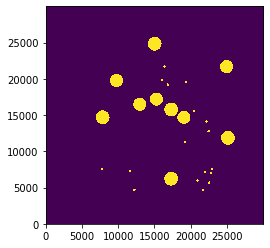

In [20]:
plt.imshow(mask, origin="lower", interpolation="nearest")
plt.savefig('Ghost_mask2.png',dpi=300)

# Appendix - catalog parameters

This cell prints the header of the catalog used in this notebook

In [16]:
# These are the name of the colums in our SExtractor catalogue
_="""header      = np.array(['ID','RA','DEC','RA_PEAK','DEC_PEAK','X','Y','MAG_AUTO','MAGERR_AUTO','KRON_RADIUS','MU_MAX','ISOAREA','MAG_ISO','MAGERR_ISO','MAG_AP1','MAG_AP2','MAG_AP3','MAG_AP4' ,  'MAG_AP5'  , 'MAG_AP6'  , 'MAG_AP7' ,  'MAG_AP8' ,  'MAG_AP_3FWHM'  , 'MAG_AP_8FWHM' ,  'MAGERR_AP1'  , 'MAGERR_AP2'  , 'MAGERR_AP3'  , 'MAGERR_AP4'  , 'MAGERR_AP5'  , 'MAGERR_AP6',   'MAGERR_AP7' ,  'MAGERR_AP5' ,  'MAGERR_AP_3FWHM'  , 'MAGERR_AP_8FWHM' ,  'FLUX_RADIUS_50' ,  'FLUX_RADIUS_90' ,  'FLAGS' ,  'CLASS_STAR'  , 'FWHM_IMAGE' ,  'BACKGROUND'  ,  'A_IMAGE'  , 'B_IMAGE' ,  'THETA_IMAGE'  , 'MAG_GROWTH_1'  , 'MAG_GROWTH_2' ,  'MAG_GROWTH_3'  , 'MAG_GROWTH_4'  , 'MAG_GROWTH_5'  , 'MAG_GROWTH_6',   'MAG_GROWTH_7' ,  'MAG_GROWTH_8' ,  'MAG_GROWTH_9'  , 'MAG_GROWTH_10' ,  'MAG_GROWTH_11' ,  'MAG_GROWTH_12'  , 'MAG_GROWTH_13'  , 'MAG_GROWTH_14' ,  'MAG_GROWTH_15'  , 'MAG_GROWTH_16' ,  'MAG_GROWTH_17' ,  'MAG_GROWTH_18'  , 'MAG_GROWTH_19' ,  'MAG_GROWTH_20'  , 'MAG_GROWTHSTEP'  , 'MAG_PSF' ,  'MAGERR_PSF' ,  'FWHMPSF_IMAGE',   'FLAGS_MODEL'  , 'MAG_MODEL' ,  'MAGERR_MODEL' ,  'MU_MAX_MODEL'  , 'MU_EFF_MODEL' ,  'XMODEL_IMAGE'  , 'YMODEL_IMAGE' ,  'AMODEL_IMAGE' ,  'BMODEL_IMAGE'  , 'THETAMODEL_IMAGE' ,  'THETAMODEL_SKY',   'SPREAD_MODEL' ,  'SPREADERR_MODEL' ,  'MAG_POINTSOURCE' ,  'MAGERR_POINTSOURCE'  , 'MAG_SPHEROID' ,  'MAGERR_SPHEROID'  , 'MU_MAX_SPHEROID' ,  'MU_EFF_SPHEROID' ,  'SPHEROID_REFF_IMAGE' ,  'SPHEROID_REFFERR_IMAGE'  , 'SPHEROID_ASPECT_IMAGE' ,  'SPHEROID_ASPECTERR_IMA' ,  'SPHEROID_SERSICN'  , 'SPHEROID_SERSICNERR' ,  'MAG_DISK' ,  'MAGERR_DISK'  , 'MU_MAX_DISK' ,  'MU_EFF_DISK' ,  'DISK_SCALE_IMAGE'  , 'DISK_SCALEERR_IMAGE' ,  'DISK_ASPECT_IMAGE'  , 'DISK_ASPECTERR_IMAGE' ,  'MAG_PETRO'  , 'MAGERR_PETRO'  , 'PETRO_RADIUS' ,  'FLUX_AUTO',    'FLUXERR_AUTO' ,  'FLUX_ISO'  ,   'FLUXERR_ISO' ,  'FLUX_MODEL' ,  'FLUXERR_MODEL'])
for i in range(len(header)):
    print(i,header[i])"""

# Appendix 2 - printing catalogue

In [17]:
# This cell exports the stars catalogue (without the fake detections)
_="""num_points, num_params = stars.shape
with open('M0416_rband_BIG_BIGSTARS_CLEAN.cat','w') as n:
    for i in range(num_points):
        for j in range(num_params):
            print(stars[i,j],end=" ",file=n)
        print(stars[i,-1],file=n)"""